In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import log

target = 100
isf = 80

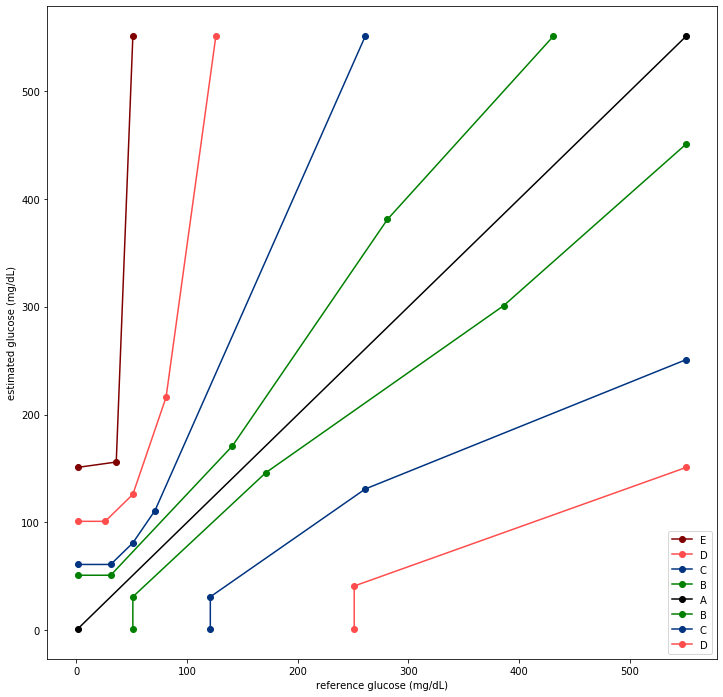

In [46]:
# Parkes Error Grid
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876371/

color = {
    "A" : (0,0,0),
    "B" : (0,0.5,0),
    "C" : (0,0.2,0.5),
    "D" : (1.0,0.3,0.3),
    "E" : (0.5,0,0),
}

lines = [
  [[0, 35, 50], [150, 155, 550], "E"],
  [[0, 25, 50, 80, 125], [100, 100, 125, 215, 550], "D"],
  [[0, 30, 50, 70, 260], [60, 60, 80, 110, 550], "C"],
  [[0, 30, 140, 280, 430], [50, 50, 170, 380, 550], "B"],
  [[0, 550], [0, 550], "A"],
  [[50, 50, 170, 385, 550], [0, 30, 145, 300, 450], "B"],
  [[120, 120, 260, 550], [0, 30, 130, 250], "C"],
  [[250, 250, 550], [0, 40, 150], "D"]
]

plt.figure(figsize=(12,12))
for line in lines:
    plt.plot(line[0], line[1], label=line[2], color=color[line[2]], marker = 'o')
plt.legend(loc='lower right')
plt.xlabel('reference glucose (mg/dL)')
plt.ylabel('estimated glucose (mg/dL)')
plt.show()


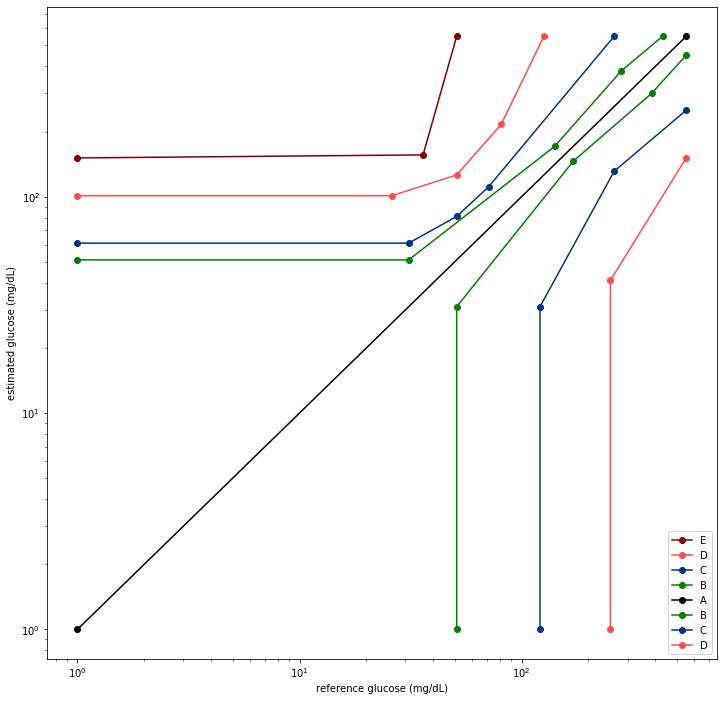

In [47]:

plt.figure(figsize=(12,12))
for line in lines:
    plt.plot(np.array(line[0])+1, np.array(line[1])+1, label=line[2], color=color[line[2]], marker = 'o')
plt.legend(loc='lower right')
plt.xlabel('reference glucose (mg/dL)')
plt.ylabel('estimated glucose (mg/dL)')
plt.xscale("log")
plt.yscale("log")
plt.show()

[[0.19864169]]
[4.96200331]
********************
[[0.24385387]]
[4.34985928]
********************
[[0.30766145]]
[3.6695669]
********************
[[0.38317039]]
[3.512605]
********************
[[1.]]
[0.]
********************
[[1.91105689]]
[-5.6123507]
********************
[[2.66528786]]
[-10.8458315]
********************
[[4.01954302]]
[-20.35300977]
********************


(-1, 7.786225720506813)

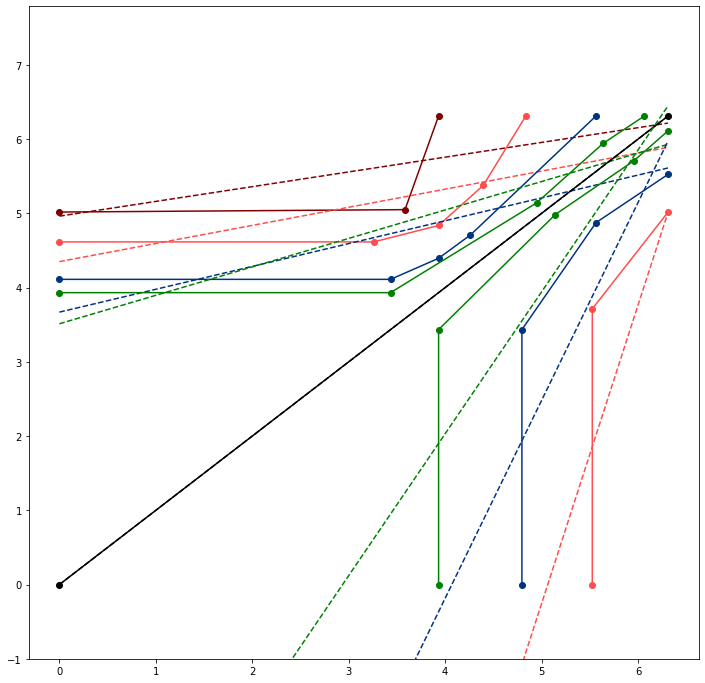

In [62]:
lfit_lines = []

plt.figure(figsize=(12,12))

for line in lines:
    x = np.log(np.array(line[0])+1).reshape(-1,1)
    y = np.log(np.array(line[1])+1).reshape(-1,1)
    plt.plot(np.log(np.array(line[0])+1), np.log(np.array(line[1])+1), label=line[2], color=color[line[2]], marker = 'o')
    reg = LinearRegression().fit(x, y)
    print(reg.coef_)
    print(reg.intercept_)
    print("********************")
    plt.plot(np.log([1,550]), reg.predict(np.log([1,550]).reshape(-1,1)), label=line[2], color=color[line[2]],linestyle='dashed')
    
    
plt.ylim(bottom=-1) 
